# Loading and exploring the data

To start I will load the json file and dump the cuisine and ingredients for each recipe into a list which can be converted to a pandas series for further manipulation. At the end I'll print the length of the lists (quick sanity check -- are the lengths the same?).

In [1]:
import pandas as pd
import numpy as np
import json

cuisines = list()
ingredients = list()
ingredients_flat = list()
with open("../recipies.json") as f:
    for entry in json.loads(f.read()):
        cuisines.append(entry['cuisine'])
        ingredients.append(", ".join(entry['ingredients']))
        ingredients_flat.extend(entry['ingredients'])

print(len(cuisines), len(ingredients))
cuisines_ser = pd.Series(cuisines, dtype=str)
ingredients_ser = pd.Series(ingredients, dtype=str)
ingredients_flat_ser = pd.Series(ingredients_flat, dtype=str)

39774 39774


I have ~40000 labeled recipes to work with.

## Exploring the classes

Let's take a look at the value_counts of our cuisines

In [2]:
cuisines_ser.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
dtype: int64

There are 20 classes (cuisines) and the dataset is imbalanced. Fortunately there doesn't appear to be any issues with typos or anything like that. Simplest approach to dealing with the imbalance is probably subsampling. For now I will integer encode the classes since I will want to use integer encodings as the target in the future classification model.

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cuisines_int_encode = label_encoder.fit_transform(cuisines_ser) # Transforming will come later!

## Exploring the ingredients

Similar to the cuisines I'll start by just looking at value_counts. I'll look at the 25 most frequent and infrequent ingredients to get an idea of what's in the data.

In [4]:
ingredients_flat_ser.value_counts().head(25)

salt                      18049
onions                     7972
olive oil                  7972
water                      7457
garlic                     7380
sugar                      6434
garlic cloves              6237
butter                     4848
ground black pepper        4785
all-purpose flour          4632
pepper                     4438
vegetable oil              4385
eggs                       3388
soy sauce                  3296
kosher salt                3113
green onions               3078
tomatoes                   3058
large eggs                 2948
carrots                    2814
unsalted butter            2782
extra-virgin olive oil     2747
ground cumin               2747
black pepper               2627
milk                       2263
chili powder               2036
dtype: int64

Not surprisingly, the most frequently appearing ingredients are probably not going to have a lot of strength in predicting the cuisine. Salt in particular I think I will simply not use as it appears in almost half of all recipes. The rest of the top 5 are likely to appear in many different classes, for now I will plan to use the TF-IDF transformation to suppress these, but simply removing them is also an option.

In [5]:
ingredients_flat_ser.value_counts(ascending=True).head(25)

bÃ©nÃ©dictine                                  1
whole grain rotini                             1
strawberry gelatin                             1
Italian seasoned panko bread crumbs            1
instant oats                                   1
rusk                                           1
low sodium canned chicken broth                1
barilla piccolini mini                         1
lemon cake mix                                 1
Franks Hot Sauce                               1
morsels                                        1
Nakano Seasoned Rice Vinegar                   1
Ragu Sauce                                     1
Hogue Cabernet Sauvignon                       1
lipton onion soup mix                          1
vegetable slaw                                 1
opo squash                                     1
Classico Pasta Sauce                           1
low-fat vegetable primavera spaghetti sauce    1
Knudsen Sour Cream                             1
cloud ear fungus    

There are a few different issues on display in this list of the least frequent recipes:
 * Overly descriptive ingredients, e.g. "whole wheat pita bread rounds"
 * Inclusion of a brand name in the ingredient, e.g. "Manischewitz Potato Starch"
 * Parsing errors, e.g. "and cook drain pasta ziti"
 
I will take the simplest way of dealing with this: I'll introduce a hyperparameter requiring ingredients to appear with greater than some frequency in order to be included in my ingredients vocabulary for the planned TF-IDF transformation. This is not the ideal approach, preferably I would find a way to map (for example) "Manischewitz Potato Starch" to "Potato Starch" and "whole wheat pita bread rounds" to "pita" or "pita bread" but in this time limited environment I will take the fast approach instead of the ideal approach.

I'll start with a minimum ingredient frequency of 50, but this is chosen arbitrarily and should be investigated later. I'll also drop salt here.

In [6]:
min_ingred_freq = 50
mask = ingredients_flat_ser.isin(ingredients_flat_ser.value_counts()[ingredients_flat_ser.value_counts() > min_ingred_freq].index)
ingredients_flat_ser = ingredients_flat_ser[mask & (ingredients_flat_ser != "salt")]

# Transforming the data with TF-IDF

I'm going to do TF-IDF a bit differently than if I was working with "proper" documents. First I'm going to binary encode using sklearn's CountVectorizer, but I'm going to use a custom tokenizer that will treat our multi-word (n-gram) ingredients as individual tokens. The upside to this is that, for example, "olive oil" and "olive(s)" will be properly treated as different ingredients. The downside is that, for example, "olive oil" and "extra-virgin olive oil" will be treated as different ingredients, when its questionable if they should be. Similar "butter" and "unsalted butter" will be treated as different ingredients, etc etc.

A better approach might be to use something like word2vec or GLoVe to learn which ingredients should be treated as the same/different from the recipe context, but I'll continue down my path of taking the simplest approach despite possibly sacrificing some predictive power.

## CountVectorizer

I'll set up CountVectorizer for the binary encoding in the cell below. I'm going to introduce another hyper-parameter here: I'll require recipes to have at least 5 ingredients that are in my vocabulary. The value 5 was chosen arbitrarily and should be reinvestigated at a later time, but what I'm trying to avoid here is recipes that with very few ingredients due to the filtering inherent in my CountVectorizer set up, and also recipes like this made up example:

Recipe = "Fries", Ingredients = "Potato wedges", "Salt"

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

min_ingred_length = 5

count_vec = CountVectorizer(vocabulary=ingredients_flat_ser.drop_duplicates().tolist(), token_pattern="(?u)\\b[\\w\\s]{1,}\\b")
count_matrix = count_vec.transform(ingredients).toarray()
mask = np.sum(count_matrix, axis=1) >= min_ingred_length
count_matrix = count_matrix[mask]
cuisines_int_encode = cuisines_int_encode[mask]
count_matrix.shape

(34583, 976)

## TF-IDF transformation

I can now use sklearn's TfidfTransformer on the count_matrix from the previous cell.

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_xformer = TfidfTransformer()
tfidf_matrix = tfidf_xformer.fit_transform(count_matrix).toarray()
tfidf_matrix.shape

(34583, 976)

# Modeling

I'm ready to classify the cuisines by recipe ingredients!

## Multinominial Naive-Bayes

For a first attempt at classification I will use sklearn's MultinomialNB model as it is usually a good choice for classifying text data. Time permitting I will use it as a benchmark model to compare to other options. First things first I'll split my data into training and testing sets using sklearn's train_test_split, stratifying to ensure the class imbalance is represented. I'll also start with a fairly conservative 50/50 train test split.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, cuisines_int_encode, test_size=0.5, stratify=cuisines_int_encode)

In [10]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

## Validating the model

In order to validate the model I'll make use of the conveniently available tools in sklearn.metrics, first the raw accuracy score on the test set. Randomly guessing from 20 classes should give 5% accuracy, hopefully my model will beat that!

In [11]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.14%


This is much better than random guessing, pretty good for a first attempt given some of the naive choices I made along the way. Next I'll plot the confusion matrix. This should give me an idea of how badly the class imbalance is affecting the model accuracy.

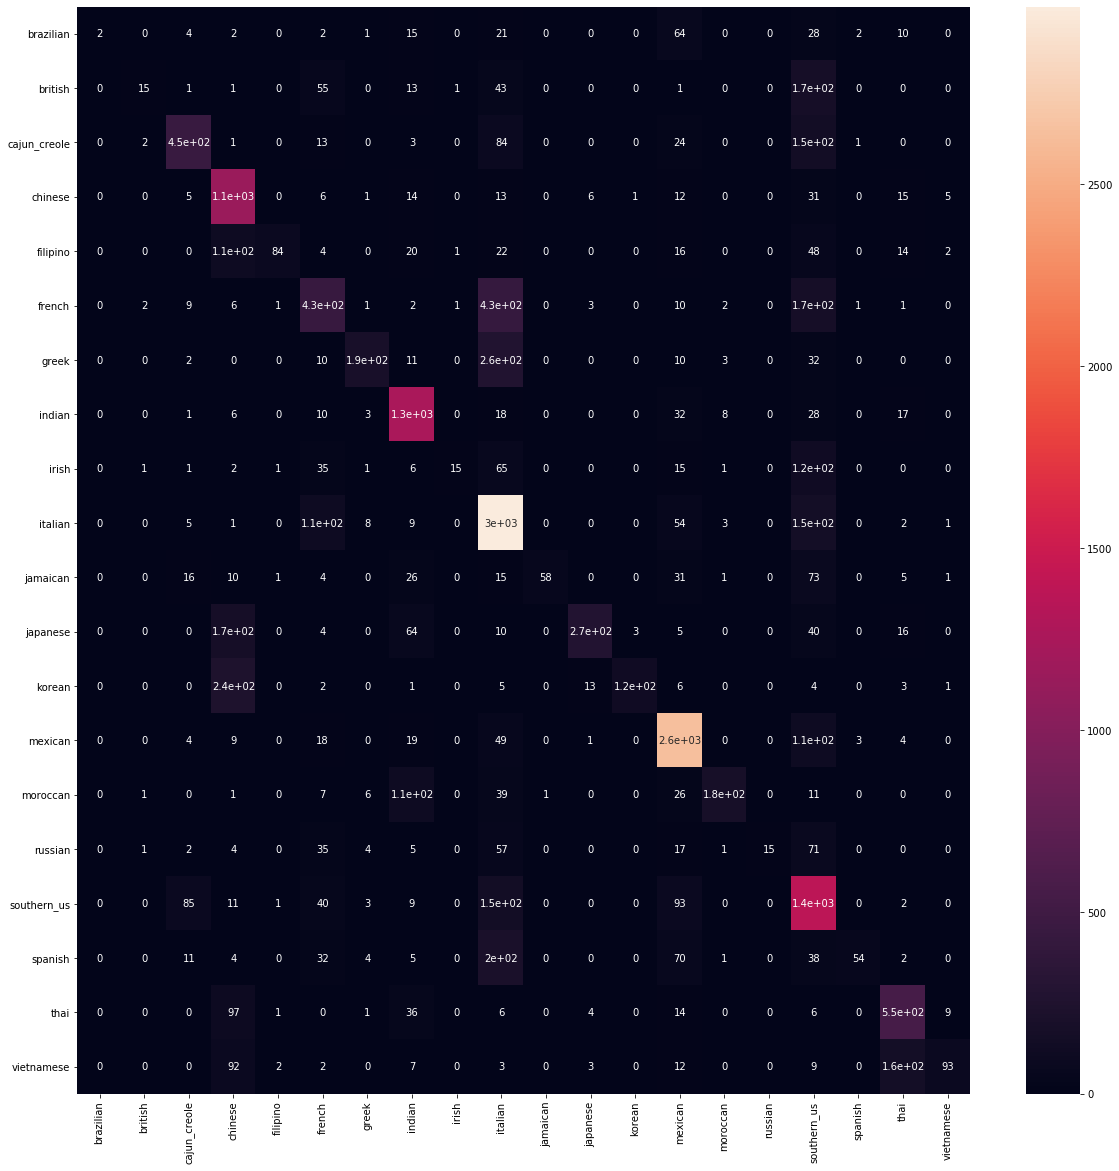

In [12]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat
plt.figure(figsize = (20,20))
sn.heatmap(pd.DataFrame(conf_mat, index = label_encoder.classes_, columns = label_encoder.classes_), annot=True)
plt.show()

### Confusion matrix discussion

There are some aspects of the confusion matrix that, in retrospect, are not surprising. 

For example, the asian cuisine categories (chinese, japanese, korean, thai, vietnamese) share many common ingredients and thus we have a hard time distinguishing them. Chinese is the majority class and much of the misclassified asian cuisine ends up there, but we can intuit that thai and vietnamese cuisine share more common ingredients with each other than with chinese cuisine as more vietnamese dishes end up classified as thai compared to chinese. Similar for italian/french/spanish, southern_us/mexican/creole, etc etc.

Removing the class imbalance should mitigate this issue to some degree, so let's try randomly subsampling.

In [13]:
# I'm going to much greedier in my train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, cuisines_int_encode, test_size=0.2, stratify=cuisines_int_encode)

# Another arbitrarily chosen number, based on the size of the classes in the train/test split
subsample_size = 225
subsampled = list()
for i in range(len(label_encoder.classes_)):
    tmp_mat = X_train[y_train == i]
    tmp_mat = tmp_mat[np.random.choice(tmp_mat.shape[0], subsample_size, replace=False)]
    tmp_arr = np.array([i] * subsample_size).reshape(-1, 1)
    subsampled.append(np.concatenate((tmp_mat, tmp_arr), axis=1))
    
matrix_subsampled = np.concatenate([mat for mat in subsampled], axis=0)
np.random.shuffle(matrix_subsampled)
X_train_sub, y_train_sub = matrix_subsampled[:,:-1], matrix_subsampled[:,-1]

clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.16%


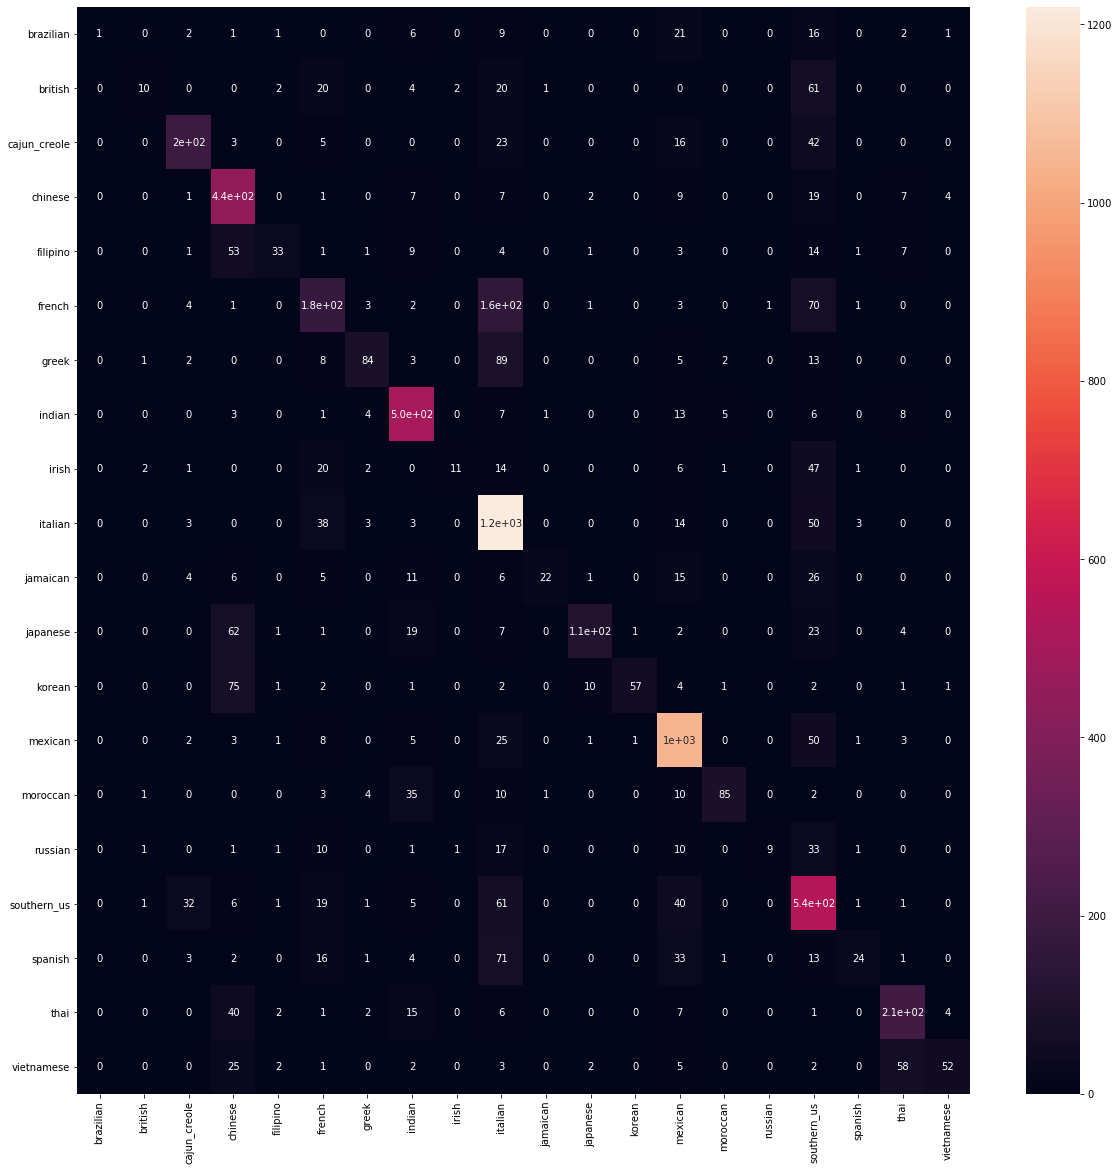

In [14]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat
plt.figure(figsize = (20,20))
sn.heatmap(pd.DataFrame(conf_mat, index = label_encoder.classes_, columns = label_encoder.classes_), annot=True)
plt.show()

### Subsampling discussion

Subsampling had a small (positive) affect on the accuracy, and indeed many of the same features are present in the confusion matrix. From this I would tentatively conclude that the problem is the similarity of recipes, i.e. shared ingredients, in the confused classes, rather than the class imbalance in the original dataset.

## Model comparison

To confirm whether MultinomialNB was a good model choice, lets compare it to some other commonly used classification models and implement stratified cross-validation at the same time.

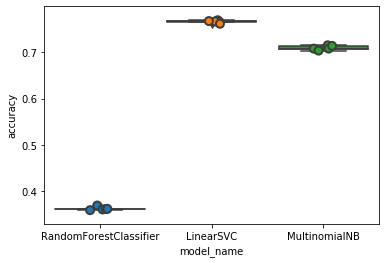

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5)
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          MultinomialNB(),]
          #LogisticRegression(random_state=0)] # Note: logisticregression with default settings does not converge

entries = []
cv_df = pd.DataFrame(index=range(5 * len(models)))
#for train_index, test_index in skf.split(tfidf_matrix, cuisines_int_encode):
#    X_train, X_test = tfidf_matrix[train_index], tfidf_matrix[test_index]
#    y_train, y_test = cuisines_int_encode[train_index], cuisines_int_encode[test_index]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, tfidf_matrix, cuisines_int_encode, scoring='accuracy', cv=skf)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        
sn.boxplot(x='model_name', y='accuracy', data=cv_df)
sn.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Trying out LinearSVC!

LinearSVC may outperform MultinomialNB based on the above, lets give it a try and check the confusion matrix.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, cuisines_int_encode, test_size=0.5, stratify=cuisines_int_encode)

linSVC = LinearSVC().fit(X_train, y_train)
y_pred = linSVC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.57%


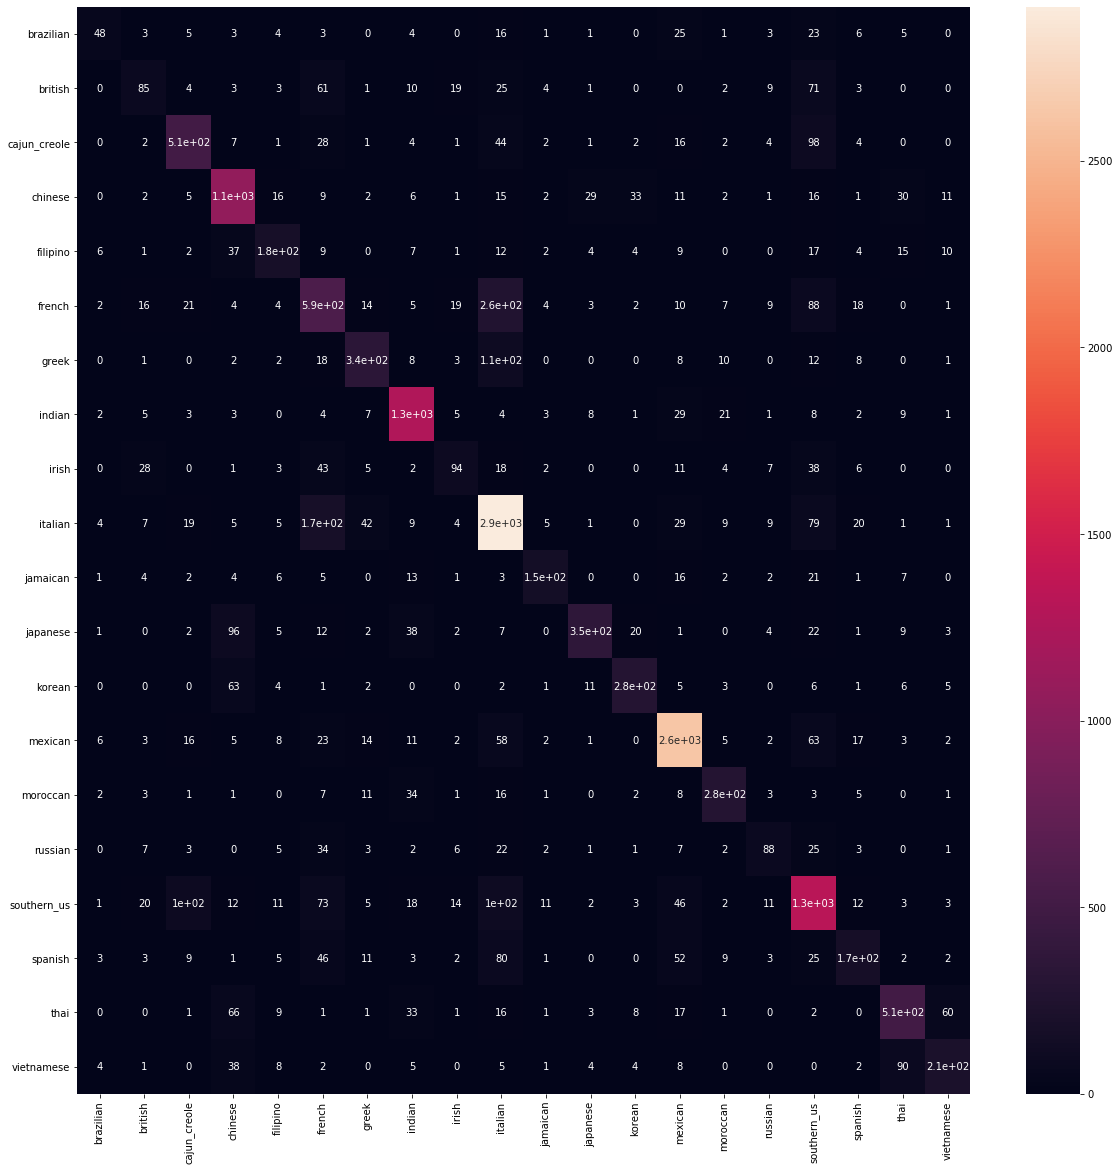

In [17]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat
plt.figure(figsize = (20,20))
sn.heatmap(pd.DataFrame(conf_mat, index = label_encoder.classes_, columns = label_encoder.classes_), annot=True)
plt.show()

LinearSVC does result in improved accuracy, but doesn't remove the fundamental problem we've seen in the confusion matrix all along! I will leave discussing my ideas for resolving that issue for the end.

# Driving ingredients per cuisine

It might have been better to look at this earlier in the process! In any case, let's look at the most common ingredients for each class

In [22]:
for cuisine in label_encoder.classes_:
    mask = cuisines_ser == cuisine
    flat_list = list()
    for row in ingredients_ser[mask].tolist():
        flat_list.extend(row.split(", "))
    tmp_ser = pd.Series(flat_list)
    print(cuisine, tmp_ser[tmp_ser != "salt"].value_counts().index[0:10].tolist())

brazilian ['onions', 'olive oil', 'lime', 'water', 'garlic cloves', 'garlic', 'cachaca', 'sugar', 'tomatoes', 'coconut milk']
british ['all-purpose flour', 'butter', 'milk', 'eggs', 'unsalted butter', 'sugar', 'onions', 'baking powder', 'large eggs', 'water']
cajun_creole ['onions', 'garlic', 'green bell pepper', 'butter', 'olive oil', 'cayenne pepper', 'cajun seasoning', 'all-purpose flour', 'water', 'garlic cloves']
chinese ['soy sauce', 'sesame oil', 'corn starch', 'sugar', 'garlic', 'water', 'green onions', 'vegetable oil', 'scallions', 'ginger']
filipino ['garlic', 'water', 'onions', 'soy sauce', 'pepper', 'oil', 'sugar', 'carrots', 'ground black pepper', 'fish sauce']
french ['sugar', 'all-purpose flour', 'unsalted butter', 'olive oil', 'butter', 'water', 'large eggs', 'garlic cloves', 'ground black pepper', 'onions']
greek ['olive oil', 'dried oregano', 'garlic cloves', 'feta cheese crumbles', 'extra-virgin olive oil', 'fresh lemon juice', 'ground black pepper', 'garlic', 'peppe

This reveals what I had stated earlier without confirming, that the classes that tended to by misclassified amongst each other in the confusion matrix, e.g. asian cuisine, european cuisine, etc, share many of their most common ingredients. TF-IDF will have supressed this effect to some degree (high frequency n-grams get a lower weight from TF-IDF) which is why the classifier works at all!

# Conclusions

I will now directly address the directions and questions in the challenge:

**1. Design and execute a method to predict the cuisine of a recipe given only its ingredients.**

I tried several different models, starting from Multinomial Naive Bayes as a benchmark, and achieved a best accuracy of ~76% using a LinearSVC, one-vs-the-rest classifier. This is significantly better than the accuracy one would expect from randomly guessing (5% for 20 cuisine classes).

**2. How could you design this to be robust enough to understand similarities / substitutions between ingredients?**

I complete avoided dealing with this in my approach, as it is not a trivial problem to solve (see major grocery chains attempting substitutions for online orders)! However, I think that word2vec could be trained on the ingredients lists, learning similarities from which ingredient "types" tend to appear together. I would guess that, for example, the vector representations for olive oil and extra virgin olive oil would be very similar.

**3. For each each major cuisine, what are the driving ingredients that characterize it?**

I provide a simple answer to this question just above, where I take the simple approach that the most frequently appearing ingredients for all recipes labeled as a particular cuisine are the driving ingredients.

**4. Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?**

The most straightforward approach, that avoids any ML, would be to use the driving ingredients lists above and label each recipe based on how many ingredients in the recipe appear in the driving ingredients lists above. The cuisine whose driving ingredients has the most overlap with the recipe ingredients should be the label for that recipe. I printed the top 10 most frequent ingredients as the driving ingredients but the choice of 10 was arbitrary, one might want to go deeper into the most frequent ingredients for this method.